# Quarterly Analysis of Sydney Housing Data

This notebook transforms the Sydney housing data to match the database schema and performs quarterly analysis.

**Target Schema:**
- `properties` table: Individual property sales with suburb, postcode, district, dates, and sale price
- `suburb_analytics` table: Aggregated metrics per suburb including quarterly time series


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [3]:
parquet_file = "../data/sydney/full.parquet"

print(f"Loading Sydney housing data from {parquet_file}...")

if Path(parquet_file).exists():
    try:
        df_raw = pd.read_parquet(parquet_file, engine='fastparquet')
    except:
        df_raw = pd.read_parquet(parquet_file)
    
    print(f"Loaded {len(df_raw):,} records")
    print(f"Date range: {df_raw['settlement_date'].min().date()} to {df_raw['settlement_date'].max().date()}")
    print(f"DataFrame shape: {df_raw.shape}")
else:
    raise FileNotFoundError(f"Parquet file not found: {parquet_file}")

print(f"\nAvailable columns: {list(df_raw.columns)}")
print("\nSample data:")
print(df_raw[['property_locality', 'property_post_code', 'district_code', 
              'contract_date', 'settlement_date', 'purchase_price']].head())


Loading Sydney housing data from ../data/sydney/full.parquet...
Loaded 1,953,809 records
Date range: 2005-01-01 to 2025-12-24
DataFrame shape: (1953809, 27)

Available columns: ['record_type', 'district_code', 'property_id', 'sale_counter', 'download_timestamp', 'property_name', 'property_unit_number', 'property_house_number', 'property_street_name', 'property_locality', 'property_post_code', 'area', 'area_type', 'contract_date', 'settlement_date', 'purchase_price', 'zoning', 'nature_of_property', 'primary_purpose', 'strata_lot_number', 'component_code', 'sale_code', 'percent_interest_of_sale', 'dealing_number', 'source_file', 'raw_record', 'year']

Sample data:
  property_locality property_post_code district_code contract_date  \
0      SOUTH COOGEE               2034           207    2005-01-01   
1        ANNANGROVE               2156           081    2004-11-21   
2            MOSMAN               2088           087    2004-12-21   
3        WOOLOOWARE               2230           

In [4]:
# transforming to match schema
print("Transforming data to match properties table schema...")

df_properties = df_raw.copy()

# column mapping
df_properties['suburb'] = df_properties['property_locality'].str.strip()
df_properties['postcode'] = df_properties['property_post_code'].astype(str).str.strip()
df_properties['district'] = df_properties['district_code'].astype(str).str.strip()
df_properties['contract_date'] = pd.to_datetime(df_properties['contract_date'])
df_properties['settlement_date'] = pd.to_datetime(df_properties['settlement_date'])
df_properties['sale_price'] = df_properties['purchase_price'].astype(float)

# days between contract and settlement
df_properties['contract_to_settlement_days'] = (
    (df_properties['settlement_date'] - df_properties['contract_date']).dt.days
)

# filter invalid records
initial_count = len(df_properties)  
df_properties = df_properties[
    (df_properties['contract_to_settlement_days'] >= 0) &
    (df_properties['contract_date'].notna()) &
    (df_properties['settlement_date'].notna()) &
    (df_properties['sale_price'] > 0) &
    (df_properties['suburb'].notna())
].copy()

print(f"Filtered from {initial_count:,} to {len(df_properties):,} valid records")
print(f"Removed {initial_count - len(df_properties):,} invalid records ({((initial_count - len(df_properties))/initial_count*100):.2f}%)")

df_properties_clean = df_properties[[
    'suburb', 'postcode', 'district', 'contract_date', 
    'settlement_date', 'sale_price', 'contract_to_settlement_days'
]].copy()

print(f"\nProperties table shape: {df_properties_clean.shape}")
print(f"\nProperties table sample:")
print(df_properties_clean.head(10))
print(f"\nProperties table info:")
print(df_properties_clean.info())


Transforming data to match properties table schema...
Filtered from 1,953,809 to 1,953,456 valid records
Removed 353 invalid records (0.02%)

Properties table shape: (1953456, 7)

Properties table sample:
            suburb postcode district contract_date settlement_date  \
0     SOUTH COOGEE     2034      207    2005-01-01      2005-01-01   
1       ANNANGROVE     2156      081    2004-11-21      2005-01-01   
2           MOSMAN     2088      087    2004-12-21      2005-01-01   
3       WOOLOOWARE     2230      144    2004-12-17      2005-01-02   
4        EDGECLIFF     2027      210    2004-12-09      2005-01-02   
5  CHIPPING NORTON     2170      223    2004-12-20      2005-01-02   
6       DACEYVILLE     2032      203    2005-01-02      2005-01-02   
7           BEXLEY     2207      142    2005-01-02      2005-01-02   
8       DACEYVILLE     2032      203    2005-01-02      2005-01-02   
9           OATLEY     2223      141    2004-12-22      2005-01-03   

   sale_price  contract_

In [5]:
# adding quarter info
df_properties['year'] = df_properties['settlement_date'].dt.year
df_properties['quarter'] = df_properties['settlement_date'].dt.quarter
df_properties['quarter_start'] = df_properties['settlement_date'].dt.to_period('Q').dt.start_time

# monthly too, just in case
df_properties['year_month'] = df_properties['settlement_date'].dt.to_period('M')

print("Added quarter and month information:")
print(df_properties[['suburb', 'settlement_date', 'year', 'quarter', 'quarter_start', 'year_month']].head(10))
print(f"\nDate range: {df_properties['settlement_date'].min()} to {df_properties['settlement_date'].max()}")
print(f"Quarters covered: {df_properties['year'].min()}Q{df_properties[df_properties['year']==df_properties['year'].min()]['quarter'].min()} to {df_properties['year'].max()}Q{df_properties[df_properties['year']==df_properties['year'].max()]['quarter'].max()}")


Added quarter and month information:
            suburb settlement_date  year  quarter quarter_start year_month
0     SOUTH COOGEE      2005-01-01  2005        1    2005-01-01    2005-01
1       ANNANGROVE      2005-01-01  2005        1    2005-01-01    2005-01
2           MOSMAN      2005-01-01  2005        1    2005-01-01    2005-01
3       WOOLOOWARE      2005-01-02  2005        1    2005-01-01    2005-01
4        EDGECLIFF      2005-01-02  2005        1    2005-01-01    2005-01
5  CHIPPING NORTON      2005-01-02  2005        1    2005-01-01    2005-01
6       DACEYVILLE      2005-01-02  2005        1    2005-01-01    2005-01
7           BEXLEY      2005-01-02  2005        1    2005-01-01    2005-01
8       DACEYVILLE      2005-01-02  2005        1    2005-01-01    2005-01
9           OATLEY      2005-01-03  2005        1    2005-01-01    2005-01

Date range: 2005-01-01 00:00:00 to 2025-12-24 00:00:00
Quarters covered: 2005Q1 to 2025Q4


In [6]:
# quarterly stats per suburb
print("Creating quarterly aggregations per suburb...")

quarterly_stats = df_properties.groupby(['suburb', 'year', 'quarter', 'quarter_start']).agg({
    'sale_price': [
        ('num_sales', 'count'),
        ('median_price', 'median'),
        ('mean_price', 'mean'),
        ('min_price', 'min'),
        ('max_price', 'max'),
        ('price_stddev', 'std'),
        ('price_p25', lambda x: x.quantile(0.25)),
        ('price_p75', lambda x: x.quantile(0.75)),
    ],
    'contract_to_settlement_days': [
        ('median_ctsd', 'median'),
        ('mean_ctsd', 'mean'),
    ]
}).reset_index()

# Flatten column names
quarterly_stats.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in quarterly_stats.columns.values]

# Calculate fast settlement percentage (typical settlement for NSW is 42 days)
fast_settlements = df_properties[df_properties['contract_to_settlement_days'] <= 42].groupby(
    ['suburb', 'year', 'quarter']
).size().reset_index(name='fast_settlement_count')

total_sales = df_properties.groupby(['suburb', 'year', 'quarter']).size().reset_index(name='total_sales_count')

fast_settlements_pct = pd.merge(fast_settlements, total_sales, on=['suburb', 'year', 'quarter'], how='right')
fast_settlements_pct['fast_settlements_percentage'] = (
    (fast_settlements_pct['fast_settlement_count'].fillna(0) / fast_settlements_pct['total_sales_count']) * 100
)

# Merge fast sales percentage into quarterly stats
quarterly_stats = pd.merge(
    quarterly_stats, 
    fast_settlements_pct[['suburb', 'year', 'quarter', 'fast_settlements_percentage']],
    on=['suburb', 'year', 'quarter'],
    how='left'
)

# Calculate liquidity score (composite of volume and speed)
#! I made a mistake here. Liquidity score is meaningless as we don't have listing date... we have contract / settlement date. We need listing for liquidity.
# Normalize volume (0-1) and speed (0-1), then combine
volume_max = quarterly_stats['sale_price_num_sales'].max()
quarterly_stats['volume_score'] = quarterly_stats['sale_price_num_sales'] / volume_max if volume_max > 0 else 0
quarterly_stats['speed_score'] = (100 - quarterly_stats['fast_settlements_percentage'].fillna(0)) / 100
quarterly_stats['liquidity_score'] = (quarterly_stats['volume_score'] * 0.6 + quarterly_stats['speed_score'] * 0.4)

print(f" Created quarterly stats for {len(quarterly_stats):,} suburb-quarter combinations")
print(f" Unique suburbs: {quarterly_stats['suburb'].nunique()}")
print(f"\nQuarterly stats sample:")
print(quarterly_stats.head(10))
print(f"\nQuarterly stats summary:")
print(quarterly_stats.describe())


Creating quarterly aggregations per suburb...
 Created quarterly stats for 48,685 suburb-quarter combinations
 Unique suburbs: 652

Quarterly stats sample:
       suburb  year  quarter quarter_start  sale_price_num_sales  \
0  ABBOTSBURY  2005        1    2005-01-01                     5   
1  ABBOTSBURY  2005        2    2005-04-01                     7   
2  ABBOTSBURY  2005        3    2005-07-01                     8   
3  ABBOTSBURY  2005        4    2005-10-01                    12   
4  ABBOTSBURY  2006        1    2006-01-01                     7   
5  ABBOTSBURY  2006        2    2006-04-01                    11   
6  ABBOTSBURY  2006        3    2006-07-01                    12   
7  ABBOTSBURY  2006        4    2006-10-01                    10   
8  ABBOTSBURY  2007        1    2007-01-01                     6   
9  ABBOTSBURY  2007        2    2007-04-01                     6   

   sale_price_median_price  sale_price_mean_price  sale_price_min_price  \
0                 54

In [ ]:
# Create suburb_analytics table structure
print("Creating suburb_analytics table...")

# Get current date for "last 12 months" calculations
current_date = df_properties['settlement_date'].max()
one_year_ago = current_date - pd.Timedelta(days=365)

# Current metrics (last 12 months)
recent_sales = df_properties[df_properties['settlement_date'] >= one_year_ago]
current_metrics = recent_sales.groupby('suburb').agg({
    'sale_price': 'median',
    'contract_to_settlement_days': 'mean',
    'settlement_date': 'count'
}).reset_index()
current_metrics.columns = ['suburb', 'current_median_price', 'current_avg_ctsd', 'total_sales_last_12m']

# Growth rates - compare current median to past periods
all_time_median = df_properties.groupby('suburb')['sale_price'].median().reset_index()
all_time_median.columns = ['suburb', 'all_time_median']

# Get median prices for different time periods
three_years_ago = current_date - pd.Timedelta(days=365*3)
five_years_ago = current_date - pd.Timedelta(days=365*5)
ten_years_ago = current_date - pd.Timedelta(days=365*10)

median_3yr_ago = df_properties[
    (df_properties['settlement_date'] >= three_years_ago - pd.Timedelta(days=90)) &
    (df_properties['settlement_date'] < three_years_ago + pd.Timedelta(days=90))
].groupby('suburb')['sale_price'].median().reset_index()
median_3yr_ago.columns = ['suburb', 'median_3yr_ago']

median_5yr_ago = df_properties[
    (df_properties['settlement_date'] >= five_years_ago - pd.Timedelta(days=90)) &
    (df_properties['settlement_date'] < five_years_ago + pd.Timedelta(days=90))
].groupby('suburb')['sale_price'].median().reset_index()
median_5yr_ago.columns = ['suburb', 'median_5yr_ago']

median_10yr_ago = df_properties[
    (df_properties['settlement_date'] >= ten_years_ago - pd.Timedelta(days=90)) &
    (df_properties['settlement_date'] < ten_years_ago + pd.Timedelta(days=90))
].groupby('suburb')['sale_price'].median().reset_index()
median_10yr_ago.columns = ['suburb', 'median_10yr_ago']

# Calculate growth rates
suburb_analytics = current_metrics.copy()
suburb_analytics = pd.merge(suburb_analytics, all_time_median, on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, median_3yr_ago, on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, median_5yr_ago, on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, median_10yr_ago, on='suburb', how='left')

# Calculate growth percentages
suburb_analytics['growth_1yr_pct'] = (
    ((suburb_analytics['current_median_price'] - suburb_analytics['median_3yr_ago']) / 
     suburb_analytics['median_3yr_ago'] * 100).fillna(0)
)
suburb_analytics['growth_3yr_pct'] = (
    ((suburb_analytics['current_median_price'] - suburb_analytics['median_5yr_ago']) / 
     suburb_analytics['median_5yr_ago'] * 100).fillna(0)
)
suburb_analytics['growth_5yr_pct'] = (
    ((suburb_analytics['current_median_price'] - suburb_analytics['median_10yr_ago']) / 
     suburb_analytics['median_10yr_ago'] * 100).fillna(0)
)

# Get earliest data point for "since 2005" growth
earliest_median = df_properties.groupby('suburb').apply(
    lambda x: x.nsmallest(min(10, len(x)), 'settlement_date')['sale_price'].median()
).reset_index()
earliest_median.columns = ['suburb', 'earliest_median']

suburb_analytics = pd.merge(suburb_analytics, earliest_median, on='suburb', how='left')
suburb_analytics['growth_since_2005_pct'] = (
    ((suburb_analytics['current_median_price'] - suburb_analytics['earliest_median']) / 
     suburb_analytics['earliest_median'] * 100).fillna(0)
)

print(f" Created analytics for {len(suburb_analytics):,} suburbs")
print(f"\nSuburb analytics sample:")
print(suburb_analytics.head(10))


Creating suburb_analytics table...
 Created analytics for 645 suburbs

Suburb analytics sample:
             suburb  current_median_price  current_avg_ctsd  \
0        ABBOTSBURY             1670000.0         66.125000   
1        ABBOTSFORD             1587500.0         54.429825   
2    ACACIA GARDENS             1290000.0         51.786667   
3       AGNES BANKS             1175000.0         82.500000   
4             AIRDS              830000.0         54.351648   
5        ALEXANDRIA             1175000.0        309.981002   
6     ALFORDS POINT             1900000.0         65.613636   
7  ALLAMBIE HEIGHTS             2600000.0         64.526882   
8           ALLAWAH              810000.0         45.418803   
9         AMBARVALE              875000.0         52.330435   

   total_sales_last_12m  all_time_median  median_3yr_ago  median_5yr_ago  \
0                    48         765000.0       1490000.0        990000.0   
1                   114        1031500.0       1235000.0  

In [25]:
# Create quarterly time series as JSON strings for suburb_analytics
print("Creating quarterly time series JSON...")

# Check available columns (for debugging)
print(f"Available columns in quarterly_stats: {list(quarterly_stats.columns)}")

# Prepare quarterly data for JSON serialization
# Note: After aggregation and flattening, column names include the aggregation suffix
# The column should be 'contract_to_settlement_days_median_ctsd' or similar
ctsd_column = [col for col in quarterly_stats.columns if 'contract_to_settlement' in col and 'median' in col.lower()]
if not ctsd_column:
    # Fallback: try to find any days on market related column
    ctsd_column = [col for col in quarterly_stats.columns if 'ctsd' in col.lower() or 'days' in col.lower()]

if ctsd_column:
    ctsd_col_name = ctsd_column[0]
    print(f"Using column: {ctsd_col_name}")
else:
    print("Warning: Could not find days on market column. Using placeholder.")
    ctsd_col_name = None

if ctsd_col_name:
    quarterly_for_json = quarterly_stats[[
        'suburb', 'year', 'quarter', 'sale_price_median_price', ctsd_col_name
    ]].copy()
    quarterly_for_json.columns = ['suburb', 'year', 'quarter', 'median_price', 'median_ctsd']
else:
    # Fallback: create a dummy column
    quarterly_for_json = quarterly_stats[[
        'suburb', 'year', 'quarter', 'sale_price_median_price'
    ]].copy()
    quarterly_for_json['median_ctsd'] = 0
    quarterly_for_json.columns = ['suburb', 'year', 'quarter', 'median_price', 'median_ctsd']

# Create price_quarterly JSON
price_quarterly_json = quarterly_for_json.groupby('suburb').apply(
    lambda x: json.dumps([
        {
            'year': int(row['year']),
            'quarter': int(row['quarter']),
            'median_price': float(row['median_price']) if pd.notna(row['median_price']) else None
        }
        for _, row in x.iterrows()
    ], default=str)
).reset_index()
price_quarterly_json.columns = ['suburb', 'price_quarterly']

# Create ctsd_quarterly JSON
ctsd_quarterly_json = quarterly_for_json.groupby('suburb').apply(
    lambda x: json.dumps([
        {
            'year': int(row['year']),
            'quarter': int(row['quarter']),
            'median_ctsd': float(row['median_ctsd']) if pd.notna(row['median_ctsd']) else None
        }
        for _, row in x.iterrows()
    ], default=str)
).reset_index()
ctsd_quarterly_json.columns = ['suburb', 'ctsd_quarterly']

# Merge JSON time series into suburb_analytics
suburb_analytics = pd.merge(suburb_analytics, price_quarterly_json, on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, ctsd_quarterly_json, on='suburb', how='left')

# Add last_updated timestamp
suburb_analytics['last_updated'] = datetime.now().isoformat()

print(" Added quarterly time series JSON")
print(f"\nSample price_quarterly JSON (first suburb):")
if len(suburb_analytics) > 0:
    sample_json = suburb_analytics.iloc[0]['price_quarterly']
    print(json.loads(sample_json)[:3] if sample_json else "No data")


Creating quarterly time series JSON...
Available columns in quarterly_stats: ['suburb', 'year', 'quarter', 'quarter_start', 'sale_price_num_sales', 'sale_price_median_price', 'sale_price_mean_price', 'sale_price_min_price', 'sale_price_max_price', 'sale_price_price_stddev', 'sale_price_price_p25', 'sale_price_price_p75', 'contract_to_settlement_days_median_ctsd', 'contract_to_settlement_days_mean_ctsd', 'fast_settlements_percentage', 'volume_score', 'speed_score', 'liquidity_score']
Using column: contract_to_settlement_days_median_ctsd
 Added quarterly time series JSON

Sample price_quarterly JSON (first suburb):
[{'year': 2005, 'quarter': 1, 'median_price': 540000.0}, {'year': 2005, 'quarter': 2, 'median_price': 471000.0}, {'year': 2005, 'quarter': 3, 'median_price': 523500.0}]


In [26]:
# Calculate volatility, market health, and liquidity scores
print("Calculating risk and market health scores...")

# Volatility: standard deviation of quarterly price changes
# Sort by suburb, year, quarter to ensure chronological order
quarterly_sorted = quarterly_stats.sort_values(['suburb', 'year', 'quarter'])
price_changes = quarterly_sorted.groupby('suburb')['sale_price_median_price'].apply(
    lambda x: x.pct_change().std() if len(x) > 1 else 0
).reset_index()
price_changes.columns = ['suburb', 'volatility_score']
price_changes['volatility_score'] = price_changes['volatility_score'].fillna(0)

# Market health: composite of growth, volume, and stability
# Calculate price trend by comparing first and last quarter (sorted chronologically)
def calculate_price_trend(group):
    """Calculate price trend from first to last quarter"""
    sorted_group = group.sort_values(['year', 'quarter'])
    if len(sorted_group) > 1:
        first_price = sorted_group['sale_price_median_price'].iloc[0]
        last_price = sorted_group['sale_price_median_price'].iloc[-1]
        if first_price > 0:
            return (last_price / first_price - 1)
    return 0

market_health = quarterly_stats.groupby('suburb').agg({
    'sale_price_num_sales': 'mean',
    'liquidity_score': 'mean',
}).reset_index()
market_health.columns = ['suburb', 'avg_volume', 'avg_liquidity']

# Calculate price trend separately with proper sorting
price_trends = quarterly_sorted.groupby('suburb').apply(
    lambda x: calculate_price_trend(x)
).reset_index()
price_trends.columns = ['suburb', 'price_trend']

market_health = pd.merge(market_health, price_trends, on='suburb', how='left')

# Normalize components and calculate composite score
market_health['market_health_score'] = (
    (market_health['avg_volume'] / market_health['avg_volume'].max() * 0.4 +
     market_health['avg_liquidity'] * 0.4 +
     (market_health['price_trend'].fillna(0) + 1) / 2 * 0.2).fillna(0)
)

# Liquidity score: average from quarterly stats
liquidity_avg = quarterly_stats.groupby('suburb')['liquidity_score'].mean().reset_index()
liquidity_avg.columns = ['suburb', 'liquidity_score']

# Merge scores into suburb_analytics
suburb_analytics = pd.merge(suburb_analytics, price_changes, on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, market_health[['suburb', 'market_health_score']], on='suburb', how='left')
suburb_analytics = pd.merge(suburb_analytics, liquidity_avg, on='suburb', how='left')

print(" Calculated risk and market health scores")
print(f"\nScore distributions:")
print(suburb_analytics[['volatility_score', 'market_health_score', 'liquidity_score']].describe())


Calculating risk and market health scores...
 Calculated risk and market health scores

Score distributions:
       volatility_score  market_health_score  liquidity_score
count        645.000000           645.000000       645.000000
mean           0.640304             0.441325         0.219874
std            3.070692             0.370903         0.032707
min            0.038982             0.067930         0.103226
25%            0.111352             0.342447         0.197867
50%            0.202090             0.412655         0.218516
75%            0.408366             0.469441         0.240542
max           71.065608             6.025357         0.352677


In [27]:
# Add rankings
print("Calculating rankings...")

suburb_analytics['price_rank'] = suburb_analytics['current_median_price'].rank(ascending=False, method='min').astype(int)
suburb_analytics['growth_rank'] = suburb_analytics['growth_1yr_pct'].rank(ascending=False, method='min').astype(int)
suburb_analytics['speed_rank'] = suburb_analytics['current_avg_ctsd'].rank(ascending=True, method='min').astype(int)  # Lower CTSD = faster = better

print(" Added rankings")
print(f"\nTop 10 suburbs by price:")
print(suburb_analytics.nlargest(10, 'current_median_price')[['suburb', 'current_median_price', 'price_rank']])
print(f"\nTop 10 suburbs by growth:")
print(suburb_analytics.nlargest(10, 'growth_1yr_pct')[['suburb', 'growth_1yr_pct', 'growth_rank']])
print(f"\nTop 10 suburbs by speed (lowest CTSD):")
print(suburb_analytics.nsmallest(10, 'current_avg_ctsd')[['suburb', 'current_avg_ctsd', 'speed_rank']])


Calculating rankings...
 Added rankings

Top 10 suburbs by price:
             suburb  current_median_price  price_rank
292     HUNTINGWOOD            21100000.0           1
481     POINT PIPER            12500000.0           2
294  HUNTLEYS POINT            11500000.0           3
81        BRADFIELD             9950000.0           4
191   DUFFYS FOREST             9700000.0           5
15     ARNDELL PARK             9460000.0           6
601     WATSONS BAY             7135000.0           7
357     LONGUEVILLE             6705000.0           8
60    BILGOLA BEACH             6687500.0           9
189   DOVER HEIGHTS             6595000.0          10

Top 10 suburbs by growth:
                   suburb  growth_1yr_pct  growth_rank
256  GREAT MACKEREL BEACH      204.232804            1
637              WOOLWICH      156.862745            2
146      COASTERS RETREAT      154.285714            3
414                MULGOA      152.336449            4
360             LUDDENHAM      137.154

In [28]:
# Display final suburb_analytics structure
print("="*80)
print("FINAL SUBURB_ANALYTICS TABLE STRUCTURE")
print("="*80)
print(f"\nShape: {suburb_analytics.shape}")
print(f"\nColumns: {list(suburb_analytics.columns)}")
print(f"\nSample data (first suburb):")
print(suburb_analytics.head(1).T)
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"\nTotal suburbs: {len(suburb_analytics):,}")
print(f"Suburbs with data in last 12 months: {len(suburb_analytics[suburb_analytics['total_sales_last_12m'] > 0]):,}")
print(f"\nPrice statistics:")
print(suburb_analytics['current_median_price'].describe())
print(f"\nGrowth statistics:")
print(suburb_analytics['growth_1yr_pct'].describe())


FINAL SUBURB_ANALYTICS TABLE STRUCTURE

Shape: (645, 22)

Columns: ['suburb', 'current_median_price', 'current_avg_ctsd', 'total_sales_last_12m', 'all_time_median', 'median_3yr_ago', 'median_5yr_ago', 'median_10yr_ago', 'growth_1yr_pct', 'growth_3yr_pct', 'growth_5yr_pct', 'earliest_median', 'growth_since_2001_pct', 'price_quarterly', 'ctsd_quarterly', 'last_updated', 'volatility_score', 'market_health_score', 'liquidity_score', 'price_rank', 'growth_rank', 'speed_rank']

Sample data (first suburb):
                                                                       0
suburb                                                        ABBOTSBURY
current_median_price                                           1670000.0
current_avg_ctsd                                                  66.125
total_sales_last_12m                                                  48
all_time_median                                                 765000.0
median_3yr_ago                                           

## Suburb-Specific Analytics

Select a suburb below to visualize its detailed analytics including quarterly trends, growth metrics, and market performance.


Analyzing suburb: NEWTOWN


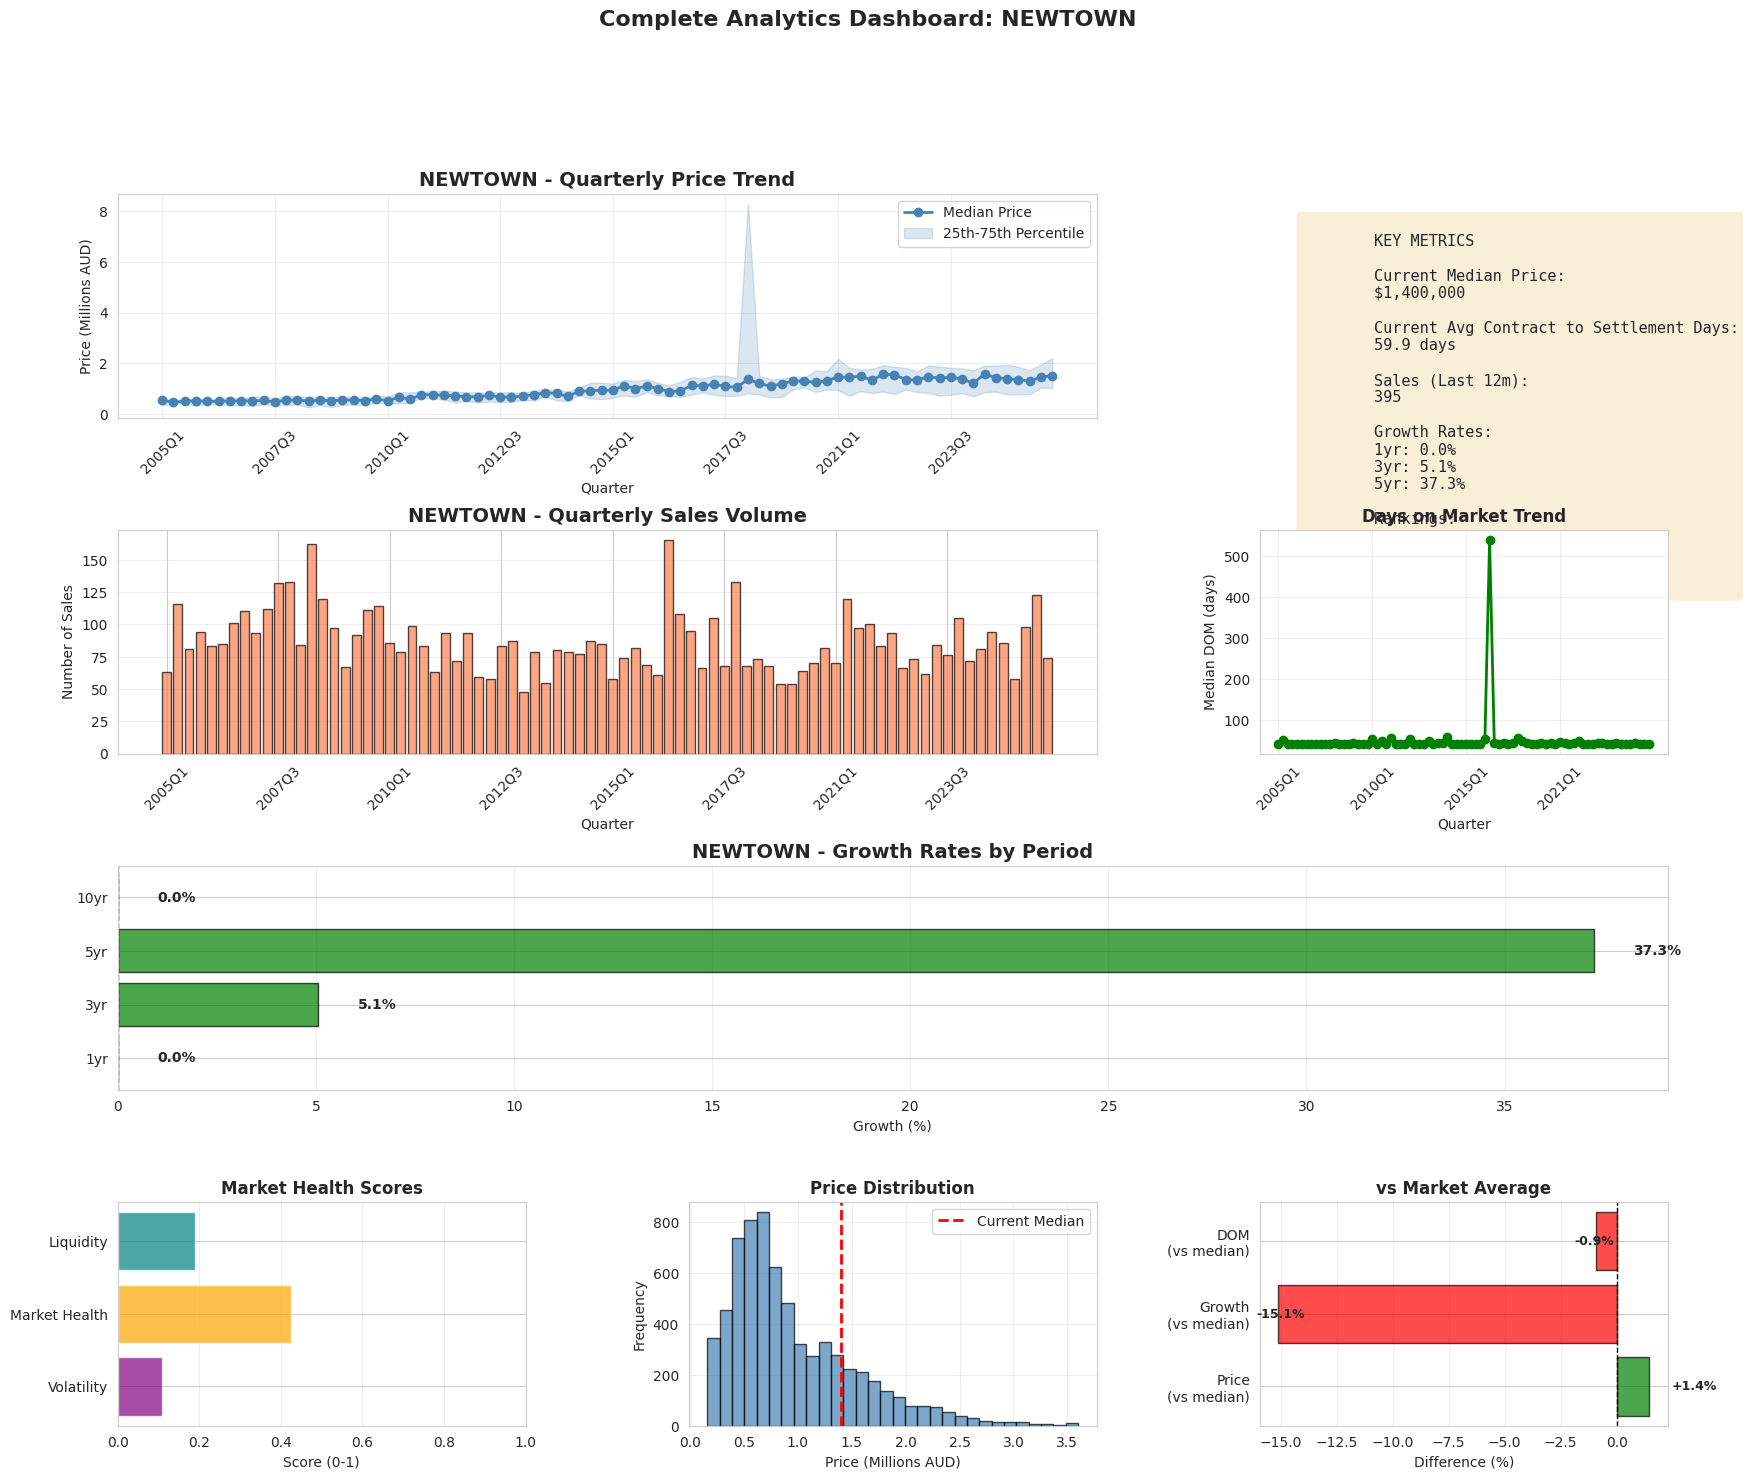


DETAILED STATISTICS FOR NEWTOWN

Price Statistics:
  Current Median: $1,400,000.00
  All-Time Median: $765,000.00
  Price Rank: #317 out of 645

Growth Statistics:
  1-Year Growth: 0.00%
  3-Year Growth: 5.07%
  5-Year Growth: 37.25%
  Growth Rank: #505

Market Performance:
  Total Sales (Last 12m): 395
  Average Days on Market: 59.9 days
  Speed Rank: #314

Risk & Health Scores:
  Volatility Score: 0.110
  Market Health Score: 0.424
  Liquidity Score: 0.189

Quarterly Data:
  Quarters with data: 80
  Date range: 2005Q1 to 2025Q4
  Average sales per quarter: 86.6


In [31]:
# Suburb-specific analytics visualization
# Change this suburb name to analyze a different suburb
SELECTED_SUBURB = "NEWTOWN"

# Get suburb data
suburb_data = suburb_analytics[suburb_analytics['suburb'].str.upper() == SELECTED_SUBURB.upper()]

if len(suburb_data) == 0:
    print(f"Suburb '{SELECTED_SUBURB}' not found. Available suburbs:")
    print(f"Total suburbs: {suburb_analytics['suburb'].nunique()}")
    print("\nSample suburbs:")
    print(suburb_analytics['suburb'].sort_values().head(20).tolist())
else:
    suburb_name = suburb_data.iloc[0]['suburb']
    print(f"Analyzing suburb: {suburb_name}")
    print("="*80)
    
    # Get quarterly data for this suburb
    suburb_quarterly = quarterly_stats[quarterly_stats['suburb'] == suburb_name].sort_values(['year', 'quarter'])
    
    if len(suburb_quarterly) == 0:
        print(f"No quarterly data found for {suburb_name}")
    else:
        # Parse JSON time series if available
        price_quarterly_json = suburb_data.iloc[0]['price_quarterly']
        ctsd_quarterly_json = suburb_data.iloc[0]['ctsd_quarterly']
        
        price_ts = json.loads(price_quarterly_json) if pd.notna(price_quarterly_json) else []
        ctsd_ts = json.loads(ctsd_quarterly_json) if pd.notna(ctsd_quarterly_json) else []
        
        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.5, wspace=0.4)
        
        # 1. Quarterly Price Trend
        ax1 = fig.add_subplot(gs[0, :2])
        if len(suburb_quarterly) > 0:
            quarters = suburb_quarterly['year'].astype(str) + 'Q' + suburb_quarterly['quarter'].astype(str)
            ax1.plot(range(len(suburb_quarterly)), suburb_quarterly['sale_price_median_price'] / 1e6, 
                    marker='o', linewidth=2, markersize=6, color='steelblue', label='Median Price')
            ax1.fill_between(range(len(suburb_quarterly)), 
                            suburb_quarterly['sale_price_price_p25'] / 1e6,
                            suburb_quarterly['sale_price_price_p75'] / 1e6,
                            alpha=0.2, color='steelblue', label='25th-75th Percentile')
            ax1.set_title(f'{suburb_name} - Quarterly Price Trend', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Quarter')
            ax1.set_ylabel('Price (Millions AUD)')
            ax1.grid(alpha=0.3)
            ax1.legend()
            ax1.set_xticks(range(0, len(suburb_quarterly), max(1, len(suburb_quarterly)//8)))
            ax1.set_xticklabels(quarters[::max(1, len(suburb_quarterly)//8)], rotation=45)
        
        # 2. Key Metrics Summary
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.axis('off')
        metrics_text = f"""
        KEY METRICS
        
        Current Median Price:
        ${suburb_data.iloc[0]['current_median_price']:,.0f}
        
        Current Avg Contract to Settlement Days:
        {suburb_data.iloc[0]['current_avg_ctsd']:.1f} days
        
        Sales (Last 12m):
        {int(suburb_data.iloc[0]['total_sales_last_12m'])}
        
        Growth Rates:
        1yr: {suburb_data.iloc[0]['growth_1yr_pct']:.1f}%
        3yr: {suburb_data.iloc[0]['growth_3yr_pct']:.1f}%
        5yr: {suburb_data.iloc[0]['growth_5yr_pct']:.1f}%
        
        Rankings:
        Price: #{int(suburb_data.iloc[0]['price_rank'])}
        Growth: #{int(suburb_data.iloc[0]['growth_rank'])}
        Speed: #{int(suburb_data.iloc[0]['speed_rank'])}
        """
        ax2.text(0.1, 0.9, metrics_text, transform=ax2.transAxes, fontsize=11,
                verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 3. Quarterly Sales Volume
        ax3 = fig.add_subplot(gs[1, :2])
        if len(suburb_quarterly) > 0:
            ax3.bar(range(len(suburb_quarterly)), suburb_quarterly['sale_price_num_sales'], 
                   color='coral', alpha=0.7, edgecolor='black')
            ax3.set_title(f'{suburb_name} - Quarterly Sales Volume', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Quarter')
            ax3.set_ylabel('Number of Sales')
            ax3.grid(axis='y', alpha=0.3)
            ax3.set_xticks(range(0, len(suburb_quarterly), max(1, len(suburb_quarterly)//8)))
            ax3.set_xticklabels(quarters[::max(1, len(suburb_quarterly)//8)], rotation=45)
        
        # 4. Days on Market Trend
        ax4 = fig.add_subplot(gs[1, 2])
        if len(suburb_quarterly) > 0 and 'contract_to_settlement_days_median_ctsd' in suburb_quarterly.columns:
            ctsdcol = 'contract_to_settlement_days_median_ctsd'
        elif len(suburb_quarterly) > 0:
            ctsdcols = [col for col in suburb_quarterly.columns if 'dom' in col.lower() or 'days' in col.lower()]
            ctsdcol = ctsdcols[0] if ctsdcols else None
        else:
            ctsdcol = None
            
        if ctsdcol and len(suburb_quarterly) > 0:
            ax4.plot(range(len(suburb_quarterly)), suburb_quarterly[ctsdcol], 
                    marker='o', linewidth=2, markersize=6, color='green')
            ax4.set_title('Days on Market Trend', fontsize=12, fontweight='bold')
            ax4.set_xlabel('Quarter')
            ax4.set_ylabel('Median DOM (days)')
            ax4.grid(alpha=0.3)
            ax4.set_xticks(range(0, len(suburb_quarterly), max(1, len(suburb_quarterly)//4)))
            ax4.set_xticklabels(quarters[::max(1, len(suburb_quarterly)//4)], rotation=45)
        
        # 5. Growth Comparison (Bar Chart)
        ax5 = fig.add_subplot(gs[2, :])
        growth_periods = ['1yr', '3yr', '5yr', '10yr']
        growth_values = [
            suburb_data.iloc[0]['growth_1yr_pct'],
            suburb_data.iloc[0]['growth_3yr_pct'],
            suburb_data.iloc[0]['growth_5yr_pct'],
            suburb_data.iloc[0]['growth_10yr_pct'] if 'growth_10yr_pct' in suburb_data.columns else 0
        ]
        colors = ['green' if v >= 0 else 'red' for v in growth_values]
        ax5.barh(growth_periods, growth_values, color=colors, alpha=0.7, edgecolor='black')
        ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax5.set_title(f'{suburb_name} - Growth Rates by Period', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Growth (%)')
        ax5.grid(axis='x', alpha=0.3)
        for i, v in enumerate(growth_values):
            ax5.text(v + (1 if v >= 0 else -1), i, f'{v:.1f}%', 
                   va='center', fontweight='bold')
        
        # 6. Market Health Scores
        ax6 = fig.add_subplot(gs[3, 0])
        scores = {
            'Volatility': suburb_data.iloc[0]['volatility_score'],
            'Market Health': suburb_data.iloc[0]['market_health_score'],
            'Liquidity': suburb_data.iloc[0]['liquidity_score']
        }
        # Normalize scores to 0-1 for radar-like visualization
        ax6.barh(list(scores.keys()), list(scores.values()), color=['purple', 'orange', 'teal'], alpha=0.7)
        ax6.set_title('Market Health Scores', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Score (0-1)')
        ax6.set_xlim(0, 1)
        ax6.grid(axis='x', alpha=0.3)
        
        # 7. Price Distribution (if we have property-level data)
        ax7 = fig.add_subplot(gs[3, 1])
        suburb_properties = df_properties[df_properties['suburb'] == suburb_name]
        if len(suburb_properties) > 0:
            # Filter outliers for better visualization
            price_q1 = suburb_properties['sale_price'].quantile(0.01)
            price_q99 = suburb_properties['sale_price'].quantile(0.99)
            prices_filtered = suburb_properties[
                (suburb_properties['sale_price'] >= price_q1) & 
                (suburb_properties['sale_price'] <= price_q99)
            ]['sale_price']
            ax7.hist(prices_filtered / 1e6, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
            ax7.axvline(suburb_data.iloc[0]['current_median_price'] / 1e6, 
                       color='red', linestyle='--', linewidth=2, label='Current Median')
            ax7.set_title('Price Distribution', fontsize=12, fontweight='bold')
            ax7.set_xlabel('Price (Millions AUD)')
            ax7.set_ylabel('Frequency')
            ax7.legend()
            ax7.grid(alpha=0.3)
        
        # 8. Comparison with Market Average
        ax8 = fig.add_subplot(gs[3, 2])
        # Calculate market averages
        market_avg_price = suburb_analytics['current_median_price'].median()
        market_avg_growth = suburb_analytics['growth_1yr_pct'].median()
        market_avg_ctsd = suburb_analytics['current_avg_ctsd'].median()
        
        suburb_price = suburb_data.iloc[0]['current_median_price']
        suburb_growth = suburb_data.iloc[0]['growth_1yr_pct']
        suburb_ctsd = suburb_data.iloc[0]['current_avg_ctsd']
        
        categories = ['Price\n(vs median)', 'Growth\n(vs median)', 'DOM\n(vs median)']
        suburb_values = [
            (suburb_price / market_avg_price - 1) * 100,
            suburb_growth - market_avg_growth,
            (suburb_ctsd / market_avg_ctsd - 1) * 100
        ]
        
        colors = ['green' if v >= 0 else 'red' for v in suburb_values]
        ax8.barh(categories, suburb_values, color=colors, alpha=0.7, edgecolor='black')
        ax8.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax8.set_title('vs Market Average', fontsize=12, fontweight='bold')
        ax8.set_xlabel('Difference (%)')
        ax8.grid(axis='x', alpha=0.3)
        for i, v in enumerate(suburb_values):
            ax8.text(v + (1 if v >= 0 else -1), i, f'{v:+.1f}%', 
                   va='center', fontweight='bold', fontsize=9)
        
        plt.suptitle(f'Complete Analytics Dashboard: {suburb_name}', fontsize=16, fontweight='bold', y=0.995)
        plt.show()
        
        # Print detailed statistics
        print("\n" + "="*80)
        print(f"DETAILED STATISTICS FOR {suburb_name}")
        print("="*80)
        print(f"\nPrice Statistics:")
        print(f"  Current Median: ${suburb_data.iloc[0]['current_median_price']:,.2f}")
        print(f"  All-Time Median: ${suburb_data.iloc[0]['all_time_median']:,.2f}")
        print(f"  Price Rank: #{int(suburb_data.iloc[0]['price_rank'])} out of {len(suburb_analytics)}")
        
        print(f"\nGrowth Statistics:")
        print(f"  1-Year Growth: {suburb_data.iloc[0]['growth_1yr_pct']:.2f}%")
        print(f"  3-Year Growth: {suburb_data.iloc[0]['growth_3yr_pct']:.2f}%")
        print(f"  5-Year Growth: {suburb_data.iloc[0]['growth_5yr_pct']:.2f}%")
        if 'growth_10yr_pct' in suburb_data.columns:
            print(f"  10-Year Growth: {suburb_data.iloc[0]['growth_10yr_pct']:.2f}%")
        print(f"  Growth Rank: #{int(suburb_data.iloc[0]['growth_rank'])}")
        
        print(f"\nMarket Performance:")
        print(f"  Total Sales (Last 12m): {int(suburb_data.iloc[0]['total_sales_last_12m'])}")
        print(f"  Average Days on Market: {suburb_data.iloc[0]['current_avg_ctsd']:.1f} days")
        print(f"  Speed Rank: #{int(suburb_data.iloc[0]['speed_rank'])}")
        
        print(f"\nRisk & Health Scores:")
        print(f"  Volatility Score: {suburb_data.iloc[0]['volatility_score']:.3f}")
        print(f"  Market Health Score: {suburb_data.iloc[0]['market_health_score']:.3f}")
        print(f"  Liquidity Score: {suburb_data.iloc[0]['liquidity_score']:.3f}")
        
        if len(suburb_quarterly) > 0:
            print(f"\nQuarterly Data:")
            print(f"  Quarters with data: {len(suburb_quarterly)}")
            print(f"  Date range: {suburb_quarterly['year'].min()}Q{suburb_quarterly['quarter'].min()} to {suburb_quarterly['year'].max()}Q{suburb_quarterly['quarter'].max()}")
            print(f"  Average sales per quarter: {suburb_quarterly['sale_price_num_sales'].mean():.1f}")
        
        print("="*80)


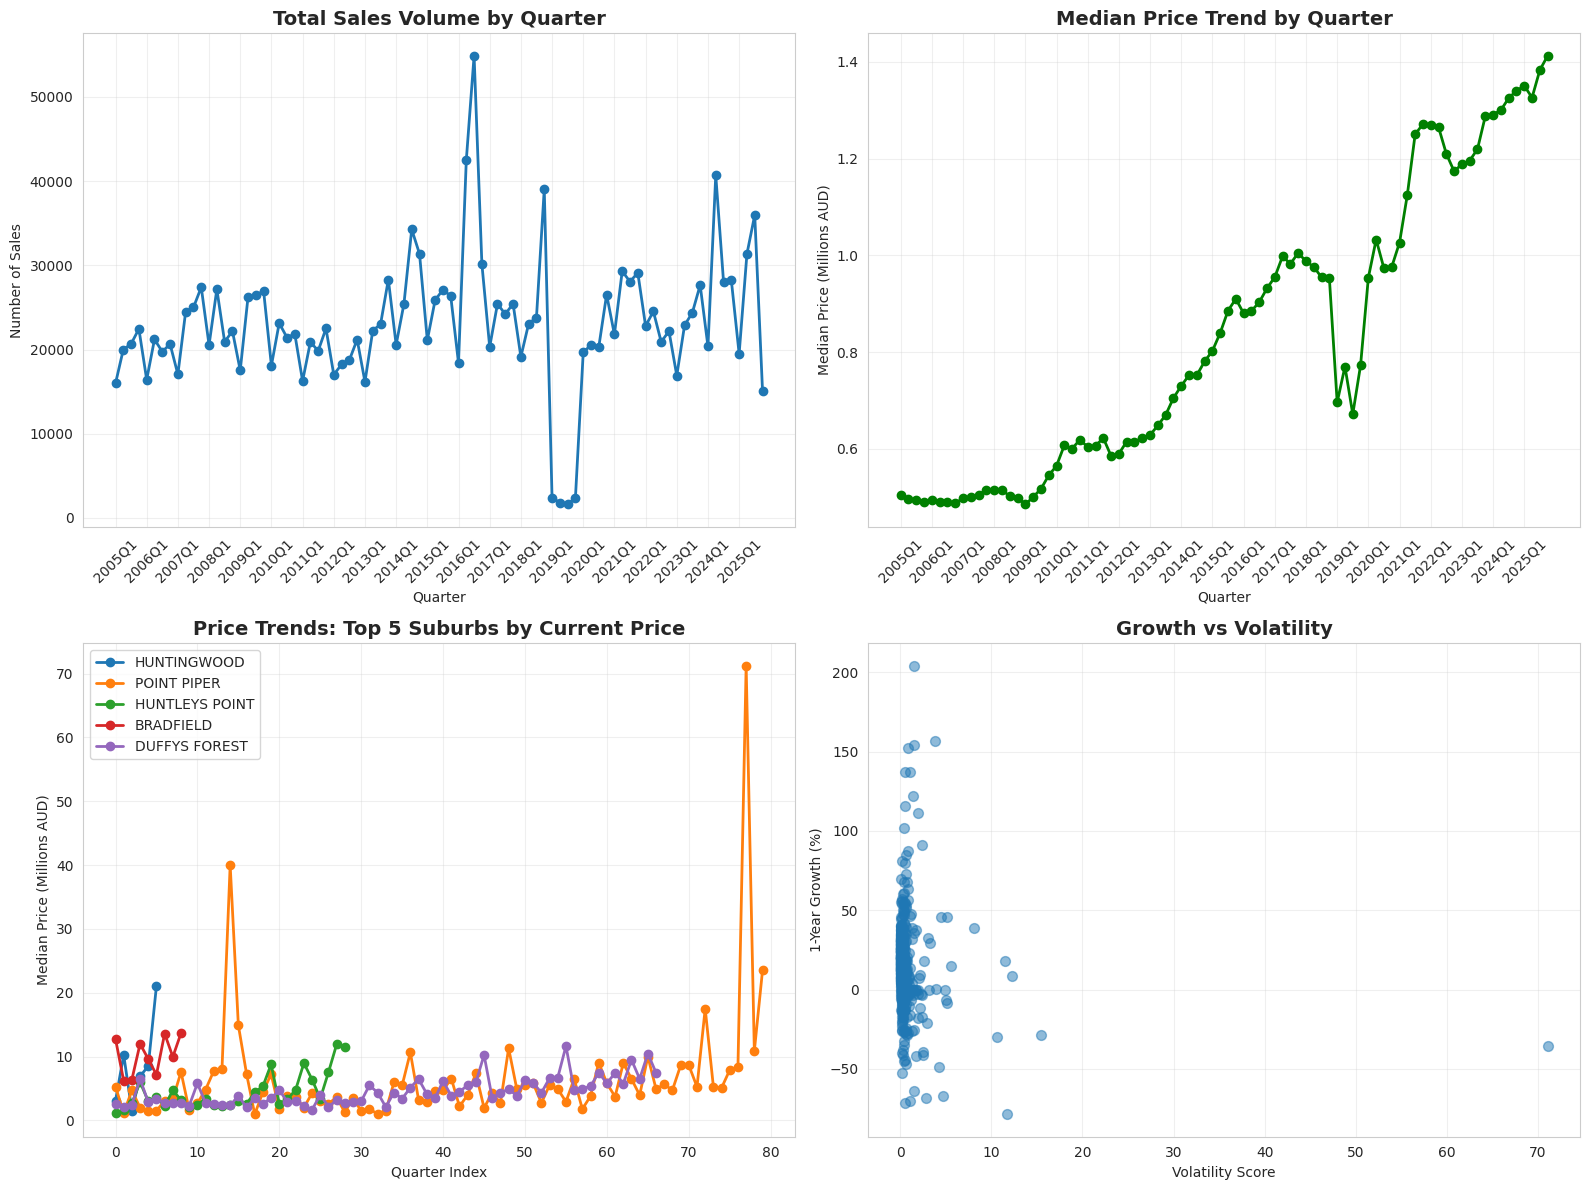

In [32]:
# Visualizations: Quarterly trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall quarterly sales volume
quarterly_volume = quarterly_stats.groupby(['year', 'quarter']).agg({
    'sale_price_num_sales': 'sum'
}).reset_index()
quarterly_volume['quarter_label'] = quarterly_volume['year'].astype(str) + 'Q' + quarterly_volume['quarter'].astype(str)
axes[0, 0].plot(range(len(quarterly_volume)), quarterly_volume['sale_price_num_sales'], marker='o', linewidth=2)
axes[0, 0].set_title('Total Sales Volume by Quarter', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Quarter')
axes[0, 0].set_ylabel('Number of Sales')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, len(quarterly_volume), 4))
axes[0, 0].set_xticklabels(quarterly_volume['quarter_label'][::4], rotation=45)

# 2. Overall median price trend
quarterly_price = quarterly_stats.groupby(['year', 'quarter']).agg({
    'sale_price_median_price': 'median'
}).reset_index()
quarterly_price['quarter_label'] = quarterly_price['year'].astype(str) + 'Q' + quarterly_price['quarter'].astype(str)
axes[0, 1].plot(range(len(quarterly_price)), quarterly_price['sale_price_median_price'] / 1e6, 
                marker='o', linewidth=2, color='green')
axes[0, 1].set_title('Median Price Trend by Quarter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Median Price (Millions AUD)')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(0, len(quarterly_price), 4))
axes[0, 1].set_xticklabels(quarterly_price['quarter_label'][::4], rotation=45)

# 3. Top 10 suburbs by current median price - quarterly trend
top_suburbs = suburb_analytics.nlargest(10, 'current_median_price')['suburb'].tolist()
top_suburbs_quarterly = quarterly_stats[quarterly_stats['suburb'].isin(top_suburbs)]
for suburb in top_suburbs[:5]:  # Show top 5 for clarity
    suburb_data = top_suburbs_quarterly[top_suburbs_quarterly['suburb'] == suburb].sort_values(['year', 'quarter'])
    axes[1, 0].plot(range(len(suburb_data)), suburb_data['sale_price_median_price'] / 1e6, 
                   marker='o', label=suburb, linewidth=2)
axes[1, 0].set_title('Price Trends: Top 5 Suburbs by Current Price', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quarter Index')
axes[1, 0].set_ylabel('Median Price (Millions AUD)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Growth vs Volatility scatter
axes[1, 1].scatter(suburb_analytics['volatility_score'], suburb_analytics['growth_1yr_pct'], 
                   alpha=0.5, s=50)
axes[1, 1].set_title('Growth vs Volatility', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Volatility Score')
axes[1, 1].set_ylabel('1-Year Growth (%)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save transformed data to parquet files
# import os

# output_dir = "../data/transformed"
# os.makedirs(output_dir, exist_ok=True)

# # Save properties table
# properties_file = f"{output_dir}/properties.parquet"
# df_properties_clean.to_parquet(properties_file, engine='fastparquet', index=False)
# print(f" Saved properties table to {properties_file}")
# print(f"  Records: {len(df_properties_clean):,}")
# print(f"  Size: {os.path.getsize(properties_file) / (1024**2):.2f} MB")

# # Save quarterly stats
# quarterly_file = f"{output_dir}/quarterly_stats.parquet"
# quarterly_stats.to_parquet(quarterly_file, engine='fastparquet', index=False)
# print(f"\nSUCCESS: Saved quarterly stats to {quarterly_file}")
# print(f"  Records: {len(quarterly_stats):,}")
# print(f"  Size: {os.path.getsize(quarterly_file) / (1024**2):.2f} MB")

# # Save suburb analytics (note: JSON columns are stored as strings)
# analytics_file = f"{output_dir}/suburb_analytics.parquet"
# suburb_analytics.to_parquet(analytics_file, engine='fastparquet', index=False)
# print(f"\nSUCCESS: Saved suburb analytics to {analytics_file}")
# print(f"  Records: {len(suburb_analytics):,}")
# print(f"  Size: {os.path.getsize(analytics_file) / (1024**2):.2f} MB")

# print("\n" + "="*80)
# print("DATA TRANSFORMATION COMPLETE")
# print("="*80)
# print("\nFiles ready for database import:")
# print(f"  1. {properties_file} -> properties table")
# print(f"  2. {analytics_file} -> suburb_analytics table")
# print(f"  3. {quarterly_file} -> (reference data for analysis)")
